# 実験３　葉のデータの機械学習  深層学習（水増しあり）

## 学習対象データ

- １２８×１２８のカラー画像　
- カテゴリ数 ７
- カテゴリあたりのデータ数１６
- 総画像数１１２

## ネットワーク構成

1.  入力層 　　（縦１２８, 横128, 3チャンネル）  
2. たたみこみ層 　　３×３  × 64チャネル
3.  プーリング層　　max プーリング　　　２x２   ストライド２
4. ドロップアウト
5.  たたみこみ層 　　３×３  × 32チャネル
6.  プーリング層　　max プーリング　　　２x２   ストライド２
7. 全結合層  256
8. ドロップアウト
9. 全結合層　　32
10. 出力層（softmax 出力）

活性化関数としてはランプ関数（　ReLU関数）を用いる。


In [17]:
import numpy as np
from PIL import Image
import os, glob, random

imgsize = 128 # 画像のサイズ
ppics = 16  # カテゴリごとの画像数  

folders = glob.glob("pics/*")

categories = [os.path.basename(c) for c in folders]
classes = len(categories)

print("クラス数=",classes, categories)

クラス数= 7 ['hanamizuki', 'kinmokusei', 'yoshino', 'yamazakura', 'hamokuren', 'keyaki', 'hananoki']


In [92]:
# 画像の読み込み
def make_dataset():
    global X
    global y
    X, y = [],[]
    folders = glob.glob("pics/*")
    # print(folders)
    for i, folder in enumerate(folders):
        files = glob.glob(folder + "/*.jpg")
        for j, file in enumerate(files):
            img = Image.open(file)
            # img = img.convert("RGB")   # もし白黒画像が含まれているなら、変換が必要
            img = img.resize((imgsize,imgsize))
            X.append(img)
        y = np.r_[y,np.array([i]*ppics,dtype=np.int32)] 
    
# データセットの生成
make_dataset()
print("データ数は",len(X))
print("正解ラベル",y)

データ数は 112
正解ラベル [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6.]


# データの水増し

In [93]:
# 画像データ x に対し、回転と反転により１８のバリエーションを作る。
# 画像X[i]　に対して、その１８画像を配列Xm[i][18]に格納する。

def rotateImages(img):
        Xadd = []
        data = np.asarray(img,dtype=np.float32)
        Xadd.append(data)
        
        for angle in range(-20, 21, 5):
            if angle != 0:
                img_angle = img.rotate(angle)
                data = np.asarray(img_angle,dtype=np.float32)
                Xadd.append(data)
                    
            img_r = img_angle.transpose(Image.FLIP_LEFT_RIGHT)
            data = np.asarray(img_r,dtype=np.float32)
            Xadd.append(data)
        return np.array(Xadd)

Xm = [] 
for i, img in enumerate(X):
    Xm.append(rotateImages(img))
    data = np.asarray(img,dtype=np.float32)
    X[i] = np.array(data)
Xm = np.array(Xm)

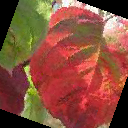

In [89]:
Image.fromarray(np.array(Xm[0][17],dtype=np.uint8))

In [98]:
X = np.array(X)
Xm.shape,X.shape

((112, 18, 128, 128, 3), (112, 128, 128, 3))

In [124]:
# データの標準化
#  経験的に、データは平均が０になっている方が効率よく学習できるので、標準化を施す。
# 元のデータは整数値であるが、標準化により実数になることに注意

from sklearn.preprocessing import StandardScaler
sc = [StandardScaler() for i in range(3)]
for i in range(3):
    sp = X[:,:,:,i].shape
    Xt = X[:,:,:,i].reshape(-1,1)
    sc[i].fit(Xt)
    X[:,:,:,i] = sc[i].transform(Xt).reshape(sp)
    # for imges in Xm:
    sp = Xm[:,:,:,:,i].shape
    Xt = Xm[:,:,:,:,i].reshape(-1,1)
    Xm[:,:,:,:,i] = sc[i].transform(Xt).reshape(sp) 

# 学習

In [125]:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense,  Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D
from keras.optimizers import Adam

from keras.utils import np_utils
import numpy as np

# 実験

学習データ１１２　（＝７カテゴリ×１６）をシャッフルしてカテゴリが偏らないように、 訓練データとテストデータに２等分し、
訓練データに対する正答率とテストデータに対する正答率を求める。

学習データ

同じ検定を５回繰り返して正答率の平均値を求めてみる。

In [128]:
#  時間がかかるので　テストように実験の繰り返しを１通りのみにしてある。本番では５通りを使うこと。
def main():
    result_train,result_test = [],[]
    # sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0) # ５通りの半々　分割
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)  #  1 通りのみ　テスト用
    count = 0
    for train_index, test_index in sss.split(X,y):
        X_train, y_train = np.zeros((0,128,128,3)),[]
        for index in train_index:
            X_train = np.r_[X_train, Xm[index]]
            y_train = np.r_[y_train, [y[index]]*18]
        X_test = X[test_index]
        y_test = y[test_index]
        
        print(X_train.shape,y_train)
        
        model = train(X_train, y_train)
        result_train.append(model_eval(model, X_train, y_train))
        result_test.append(model_eval(model, X_test, y_test))
        print('train loss=',result_train[count][0])
        print('train accuracy=',result_train[count][1])
        print('test loss=',result_test[count][0])
        print('test accuracy=',result_test[count][1])
        count = count+1
    return model,train_index,test_index,result_train,result_test
            
def train(X, y):
    model = Sequential()
    
    model.add(Conv2D(64,3,input_shape=(128,128,3)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(32,3))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(classes,activation='softmax'))
    
    adam = Adam(lr=1e-4)
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=adam, metrics=['accuracy'])
    model.fit(X,y,epochs=10)
    return model

def model_eval(model, X, y):
    score = model.evaluate(X,y)
    return score

学習の実行

In [129]:
model,train_index,test_index,result_train,result_test = main()

(1008, 128, 128, 3) [ 3.  3.  3. ...,  0.  0.  0.]
Epoch 1/10
1008/1008 [==============================] - 64s 63ms/step - loss: 1.4252 - acc: 0.4355
Epoch 2/10
1008/1008 [==============================] - 61s 60ms/step - loss: 0.6605 - acc: 0.7540
Epoch 3/10
1008/1008 [==============================] - 60s 60ms/step - loss: 0.2681 - acc: 0.9335
Epoch 4/10
1008/1008 [==============================] - 60s 60ms/step - loss: 0.1265 - acc: 0.9752
Epoch 5/10
1008/1008 [==============================] - 61s 60ms/step - loss: 0.0805 - acc: 0.9841
Epoch 6/10
1008/1008 [==============================] - 65s 64ms/step - loss: 0.0410 - acc: 0.9950
Epoch 7/10
1008/1008 [==============================] - 59s 59ms/step - loss: 0.0299 - acc: 0.9960
Epoch 8/10
1008/1008 [==============================] - 60s 59ms/step - loss: 0.0257 - acc: 0.9980
Epoch 9/10
1008/1008 [==============================] - 59s 59ms/step - loss: 0.0191 - acc: 0.9980
Epoch 10/10
56/56 [==============================] - 1s 18

# 正認識率


In [136]:
trainaccav, testaccav = 0,0 
n = len(result_train)
for i in range(n):
    print("{0}回目　　　　訓練データ正解率{1:5.1f}%　 　テストデータ正解率{２:5.1f}%".format(i,result_train[i][1]*100, result_test[i][1]*100))
    trainaccav, testaccav = trainaccav+ result_train[i][1], testaccav+result_test[i][1]  

print("平均正認識率　　　　訓練データ　 {0:5.1f}%　     テストデータ　 {1:5.1f}%　　".format(trainaccav/n*100,testaccav/n*100))

0回目　　　　訓練データ正解率100.0%　 　テストデータ正解率 57.1%
平均正認識率　　　　訓練データ　 100.0%　     テストデータ　  57.1%　　


# 詳細な認識結果
５回試みた学習のうち、最終回の学習結果による全データの認識結果

In [138]:
pred = model.predict_classes(X)
for i in range(7):
    for j in range(16):
        print("{}/{}".format(i,pred[16*i+j]), end="     ")
    print()

0/6     0/0     0/0     0/5     0/0     0/0     0/0     0/4     0/0     0/0     0/0     0/2     0/0     0/0     0/0     0/6     
1/1     1/1     1/1     1/1     1/1     1/1     1/1     1/1     1/1     1/1     1/1     1/3     1/1     1/2     1/1     1/2     
2/2     2/2     2/2     2/6     2/2     2/2     2/2     2/2     2/2     2/2     2/2     2/2     2/2     2/2     2/2     2/6     
3/3     3/3     3/3     3/5     3/5     3/3     3/3     3/1     3/3     3/3     3/3     3/3     3/3     3/3     3/3     3/3     
4/4     4/1     4/4     4/4     4/4     4/4     4/4     4/6     4/4     4/4     4/5     4/4     4/4     4/4     4/4     4/4     
5/5     5/5     5/5     5/3     5/2     5/5     5/5     5/5     5/5     5/5     5/5     5/3     5/5     5/5     5/0     5/5     
6/6     6/6     6/6     6/2     6/0     6/6     6/6     6/3     6/6     6/0     6/6     6/6     6/6     6/6     6/6     6/6     


# 誤認識の解析

（以下は考察の例　 　上の結果に基づいて記入する）

一例として、最後のケースについて、 正解不正解の和人誤認識例を確認してみると、

||カテゴリ |正認識数 |誤認識数|誤認識されたカテゴリ|
|:--------------:|:-----------:|:----------:|:--------:|:---------------|
|0|ハナミズキ|9|7||
|1|キンモクセイ|１1|5||
|２|ソメイヨシノ|9|7|　|
|３|ヤマザクラ|１1|5||  
|４|ハモクレン|１3|3||
|５|ケヤキ|11|5||  
|６|ハナノキ|１3|3||